In [1]:
import pathlib
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
from scipy.cluster import hierarchy
from sklearn import cluster, datasets, preprocessing

plt.style.use("seaborn-colorblind")

%matplotlib inline

In [2]:
img = pathlib.Path("../../img/clusters/")
img.mkdir(exist_ok=True)

# Creating the datasets

As representative shapes, we are using moons, ellipses (elongated spheres), and spheres.

In [3]:
n_samples = 300
noise = 0.05
seed = 3

moons, _ = datasets.make_moons(
    n_samples=n_samples, noise=noise, random_state=seed
)

ellipses, _ = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.4, 0.8], [-0.6, 0.1]]
ellipses = np.dot(ellipses, transformation)

spheres, _ = datasets.make_blobs(n_samples=n_samples, centers=4, random_state=seed)

In [4]:
summaries = (
    ("Moons", "Interlocking crescent moons", 2, r"\xmark", r"\xmark", r"\xmark"),
    ("Ellipses", "Elongated globules", 3, r"\cmark", r"\cmark", r"\xmark"),
    ("Spheres", "Rough-edged balls", 4, r"\cmark", r"\cmark", r"\cmark"),
)

description = pd.DataFrame.from_records(
    summaries, columns=["Name", "Summary", "No. clusters", "Convex", "Separable", "Isotropic"], index="Name"
)

description.to_latex("../../tex/datasets.tex", column_format="llrccc", bold_rows=True, multicolumn=False, escape=False)
description

,Summary,No. clusters,Convex,Separable,Isotropic
Name,,,,,
Moons,Interlocking crescent moons,2,\xmark,\xmark,\xmark
Ellipses,Elongated globules,3,\cmark,\cmark,\xmark
Spheres,Rough-edged balls,4,\cmark,\cmark,\cmark


# Plotting functions

### `plot_scatter`

A simple scatter plot. If using $k$-means, the cluster centres and Voronoi cells are also plotted, and for DBSCAN, the outliers are plotted separately.

### `plot_dendogram`

A truncated dendogram for the hierarchical clustering. The colour of the subtrees matches the associated scatter plot.

In [5]:
def _get_cluster_colours(n_clusters, cmap):
    """Retrieve the set of colours used to create `n_clusters` scatters."""

    norm = plt.matplotlib.colors.Normalize(vmin=0, vmax=n_clusters - 1)
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return [
        plt.matplotlib.colors.rgb2hex(m.to_rgba(i)[:-1]) for i in range(n_clusters)
    ]

def _get_voronoi_cells(centres):
    """Given a set of cluster centres, find the vertices and edges of their
    associated Voronoi cells.
    
    Adapted from https://nbviewer.jupyter.org/gist/pv/8037100
    """

    voronoi = spatial.Voronoi(centres)

    new_regions = []
    new_vertices = voronoi.vertices.tolist()

    center = voronoi.points.mean(axis=0)
    radius = voronoi.points.ptp().max() * 10

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(voronoi.point_region):
        vertices = voronoi.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = voronoi.points[p2] - voronoi.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = voronoi.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = voronoi.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


def plot_scatter(data, method, lims=(-2.6, 2.6), cmap=plt.cm.viridis, fill_alpha=0.2, fill_zorder=-2, filename=None, **kwargs):
    """Make the requisite scatter plot for a dataset and a particular method."""

    _, ax = plt.subplots(dpi=300)

    m = method(**kwargs)
    scaled = preprocessing.StandardScaler().fit_transform(data.copy())
    m = m.fit(scaled)

    labels = m.labels_
    outlier_mask = labels == -1
    inliers = scaled[~outlier_mask, :]
    outliers = scaled[outlier_mask, :]

    scatter = ax.scatter(
        inliers[:, 0],
        inliers[:, 1],
        s=60,
        c=labels[~outlier_mask],
        cmap=cmap,
        alpha=1.,
        lw=0.5,
        ec="lightgray",
    )

    ax.scatter(
        outliers[:, 0], outliers[:, 1], marker="s", s=20, c="None", ec="k"
    )

    if isinstance(m, cluster.KMeans):
        n_clusters = m.n_clusters
        alpha = 0.2
        edges = ["lightgray"] * (n_clusters - 1) + ["darkgray"]

        colours = _get_cluster_colours(n_clusters, cmap)
        centres = m.cluster_centers_
        if n_clusters == 2:
            xs = np.linspace(-10, 10, 100)
            gradient = - np.diff(centres[:, 0]) / np.diff(centres[:, 1])
            midpoint = centres.mean(axis=0)
            intercept = midpoint[1] - gradient * midpoint[0]
            ys = gradient * xs + intercept
            for i, centre in enumerate(centres):
                extreme = max if centre[1] == max(centres[:, 1]) else min
                ax.fill_between(xs, ys, extreme(ys), color=colours[i], ec="None", alpha=fill_alpha, zorder=fill_zorder)
        else:
            regions, vertices = _get_voronoi_cells(centres)
            for i, region in enumerate(regions):
                polygon = vertices[region]
                ax.fill(*zip(*polygon), fc=colours[i], alpha=fill_alpha, zorder=fill_zorder)

        ax.scatter(
            centres[:, 0],
            centres[:, 1],
            marker="X",
            s=200,
            c=range(n_clusters),
            ec=edges,
        )

    ax.set(aspect="equal", xticks=[], yticks=[], xlim=lims, ylim=lims)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, transparent=True, bbox_inches='tight', pad_inches=0.25)

In [6]:
def _get_leaf_colours(data, criterion, n_clusters, cmap):
    """Identify the colours used for each point in a scatter of `data` into `n_clusters`
    parts with the colour map `cmap`."""

    cluster_colours = _get_cluster_colours(n_clusters, cmap)
    labels = cluster.AgglomerativeClustering(n_clusters=n_clusters, linkage=criterion).fit(data).labels_

    return {i: cluster_colours[label] for i, label in enumerate(labels)}

    
def _get_link_colours(linkage_matrix, leaf_colours, default_colour):
    """Get the links to be coloured according to the leaves of the dendogram."""

    link_colours = {}
    for i, link in enumerate(linkage_matrix[:,:2].astype(int)):
        c1, c2 = (link_colours[l] if l > len(linkage_matrix) else leaf_colours[l] for l in link)
        link_colours[i + 1 + len(linkage_matrix)] = c1 if c1 == c2 else default_colour

    return link_colours


def plot_dendogram(data, n_clusters, cmap=plt.cm.viridis, default_colour="#808080", criterion="average", filename=None, **kwargs):
    """Create the linkage matrix for a dataset and then plot the dendrogram."""

    _, ax = plt.subplots(dpi=300)

    scaled = preprocessing.StandardScaler().fit_transform(data.copy())
    leaf_colours = _get_leaf_colours(scaled, criterion, n_clusters, cmap)
    
    linkage_matrix = hierarchy.linkage(scaled, criterion)
    link_colours = _get_link_colours(linkage_matrix, leaf_colours, default_colour)
    
    hierarchy.dendrogram(
        linkage_matrix,
        ax=ax,
        color_threshold=None,
        link_color_func=lambda x: link_colours[x],
        **kwargs
    )

    ax.set(
        xticks=[],
        yticks=[],
    )

    ax.axis("off")

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, transparent=True, bbox_inches='tight', pad_inches=0.25)

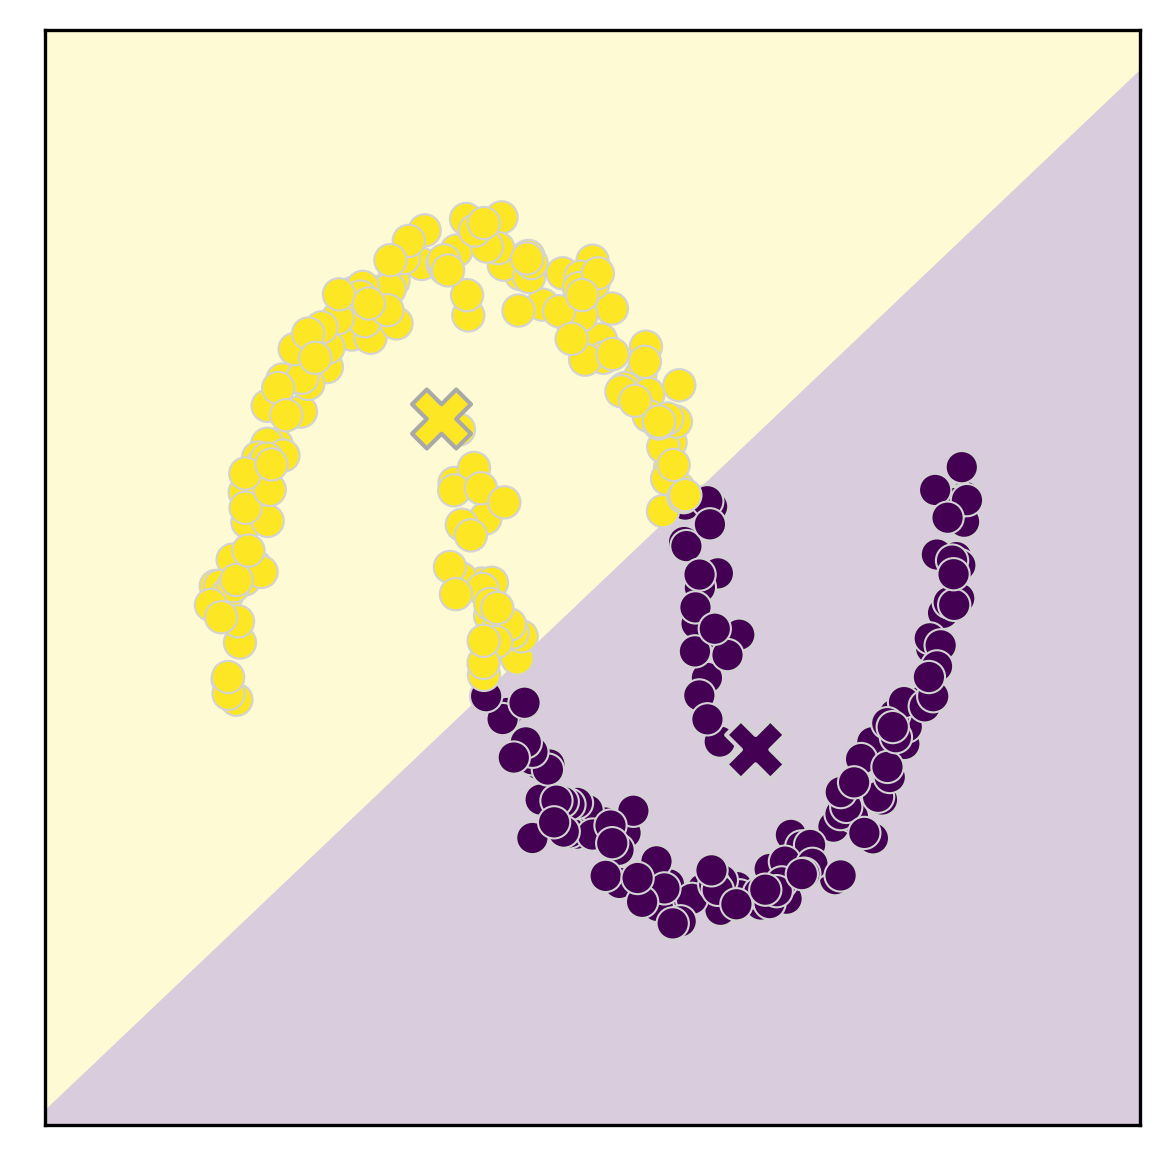

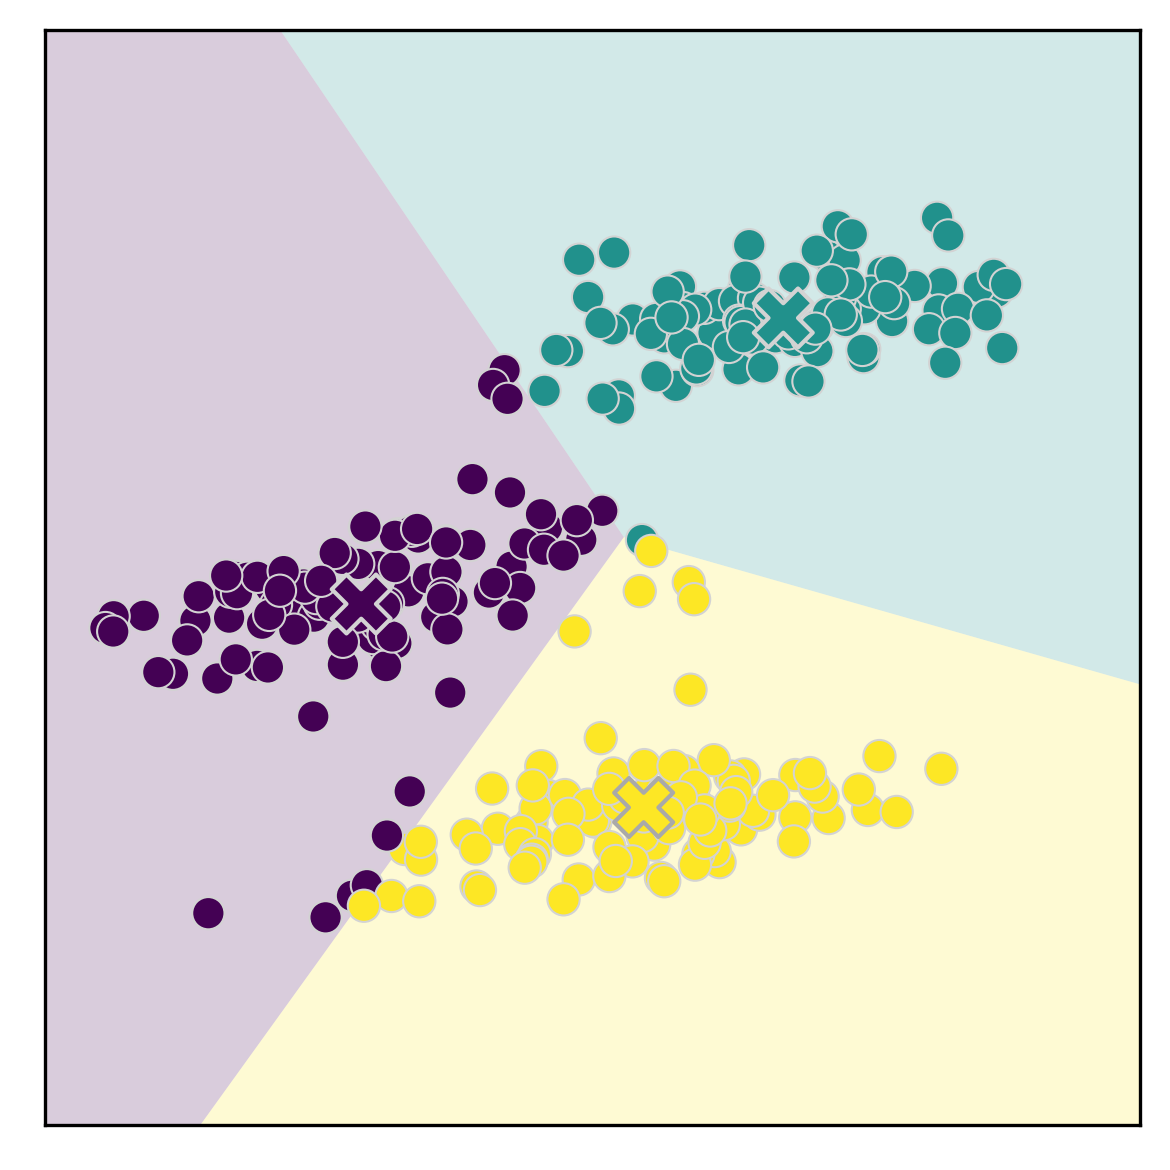

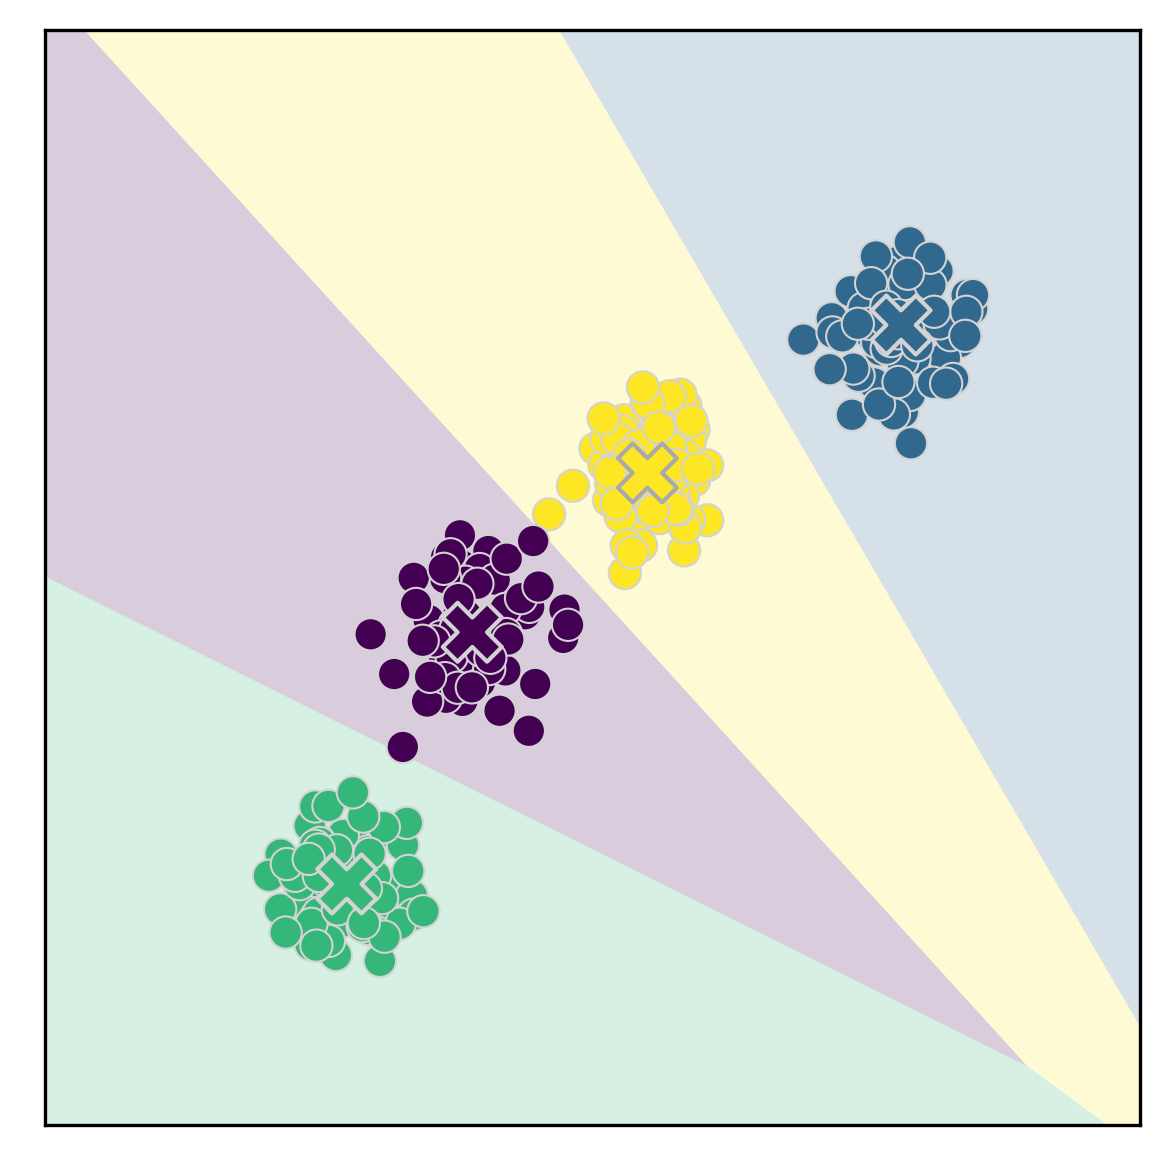

In [7]:
for n_clusters, data, name in zip(
    (2, 3, 4), (moons, ellipses, spheres), ("moons", "ellipses", "spheres")
):
    plot_scatter(
        data,
        cluster.KMeans,
        filename=img / f"kmeans_{name}.pdf",
        n_clusters=n_clusters,
        random_state=0,
    )

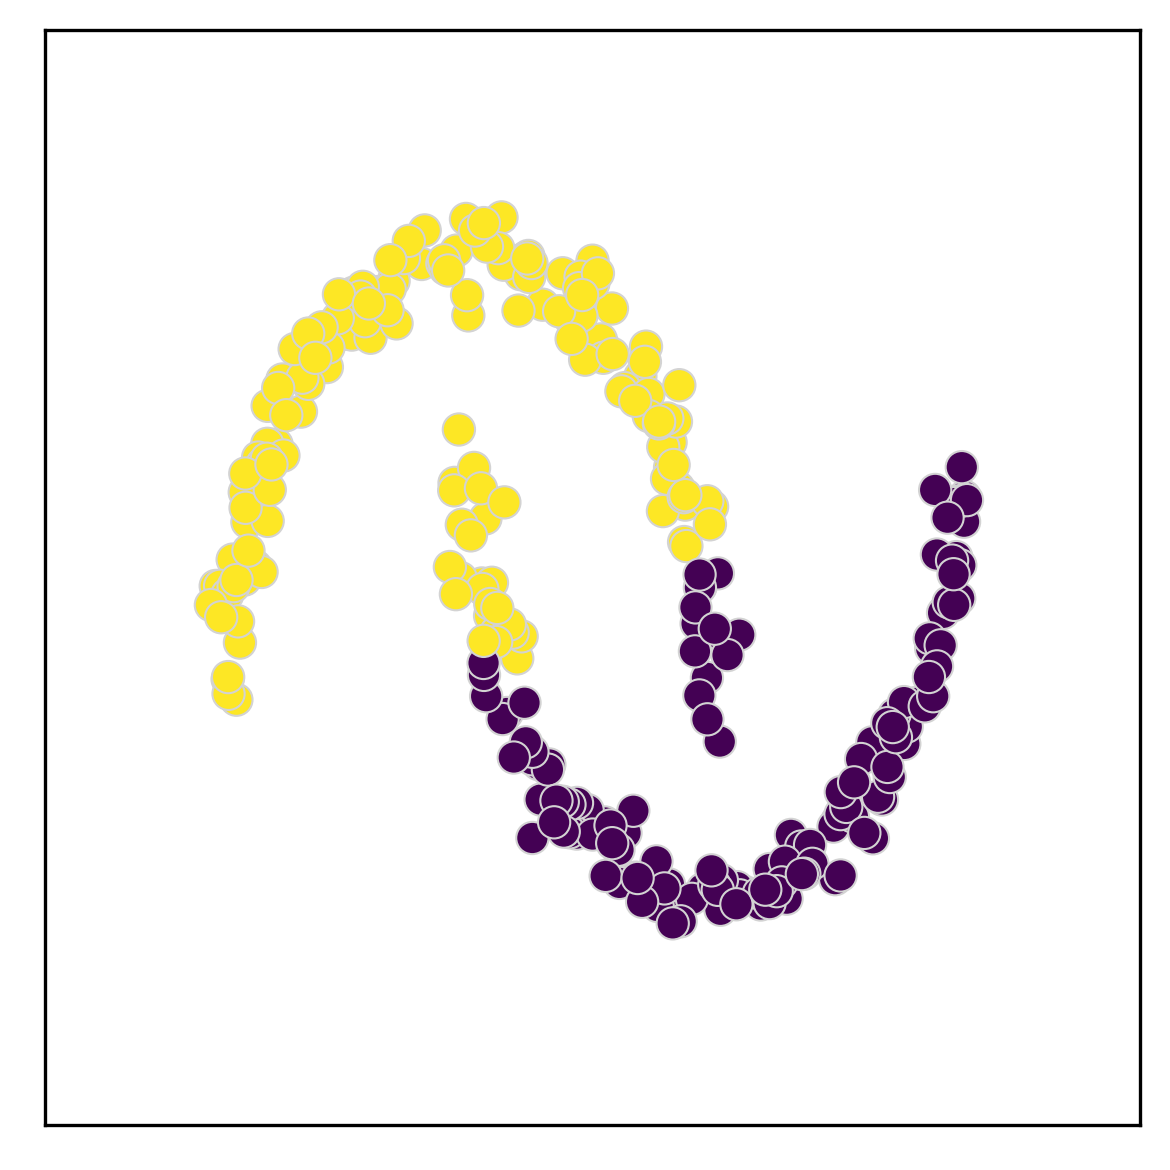

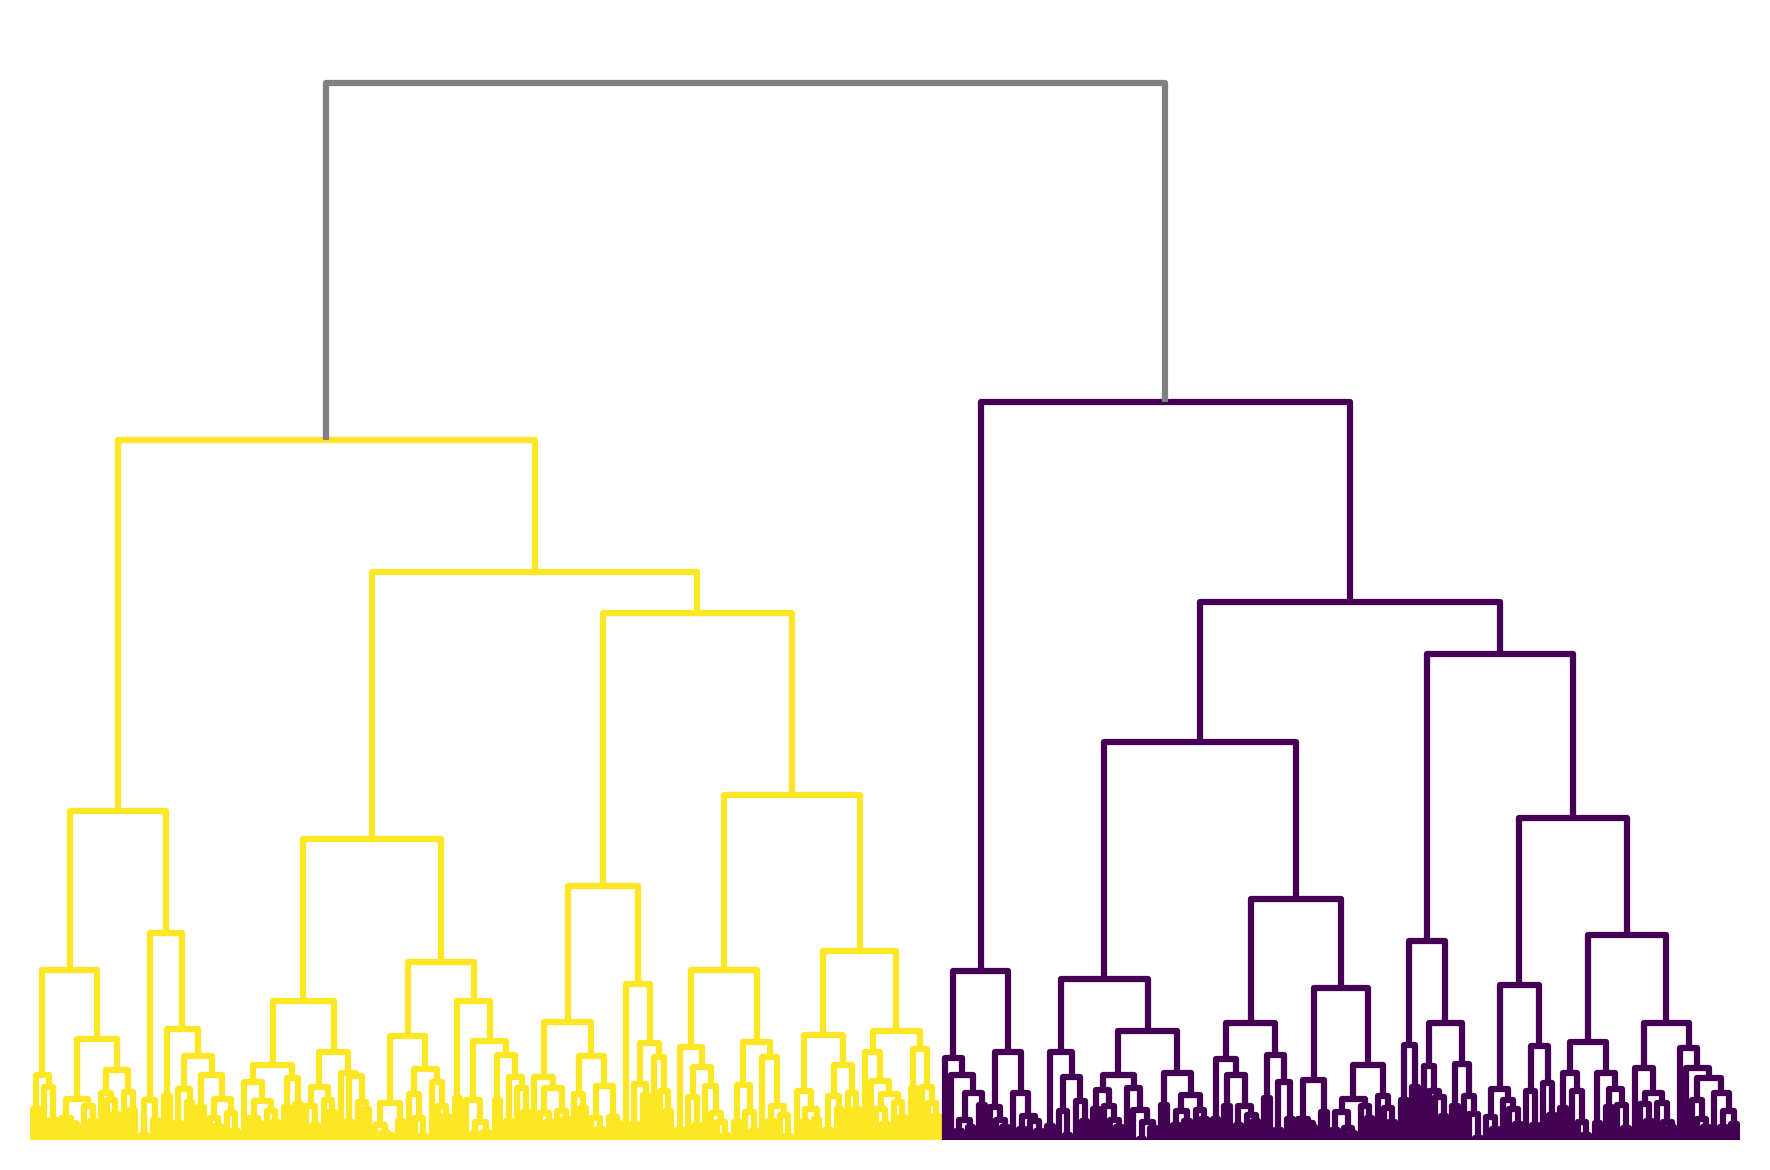

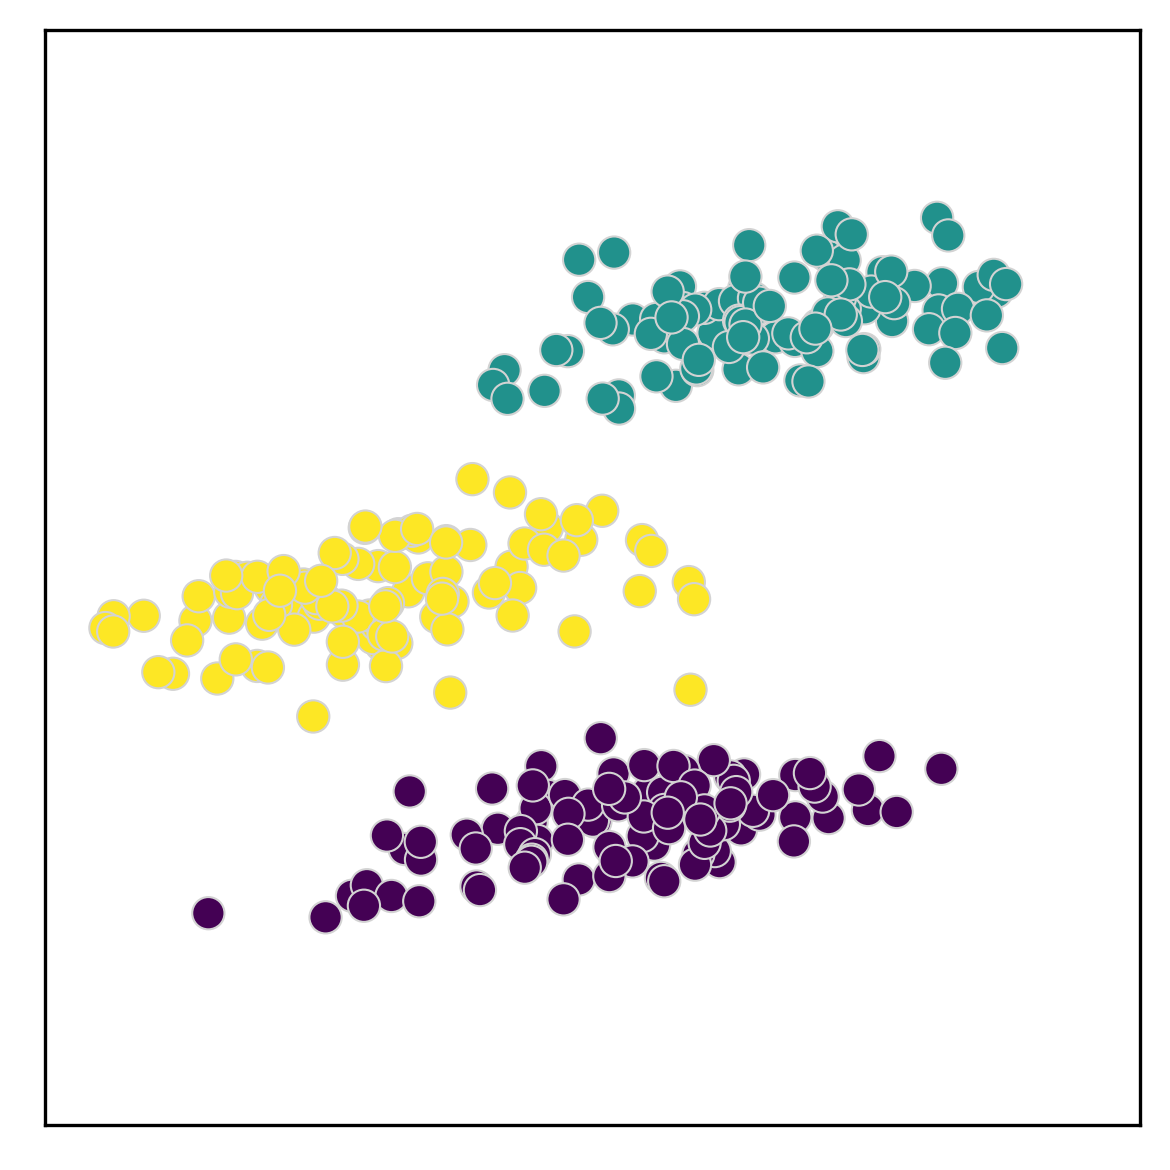

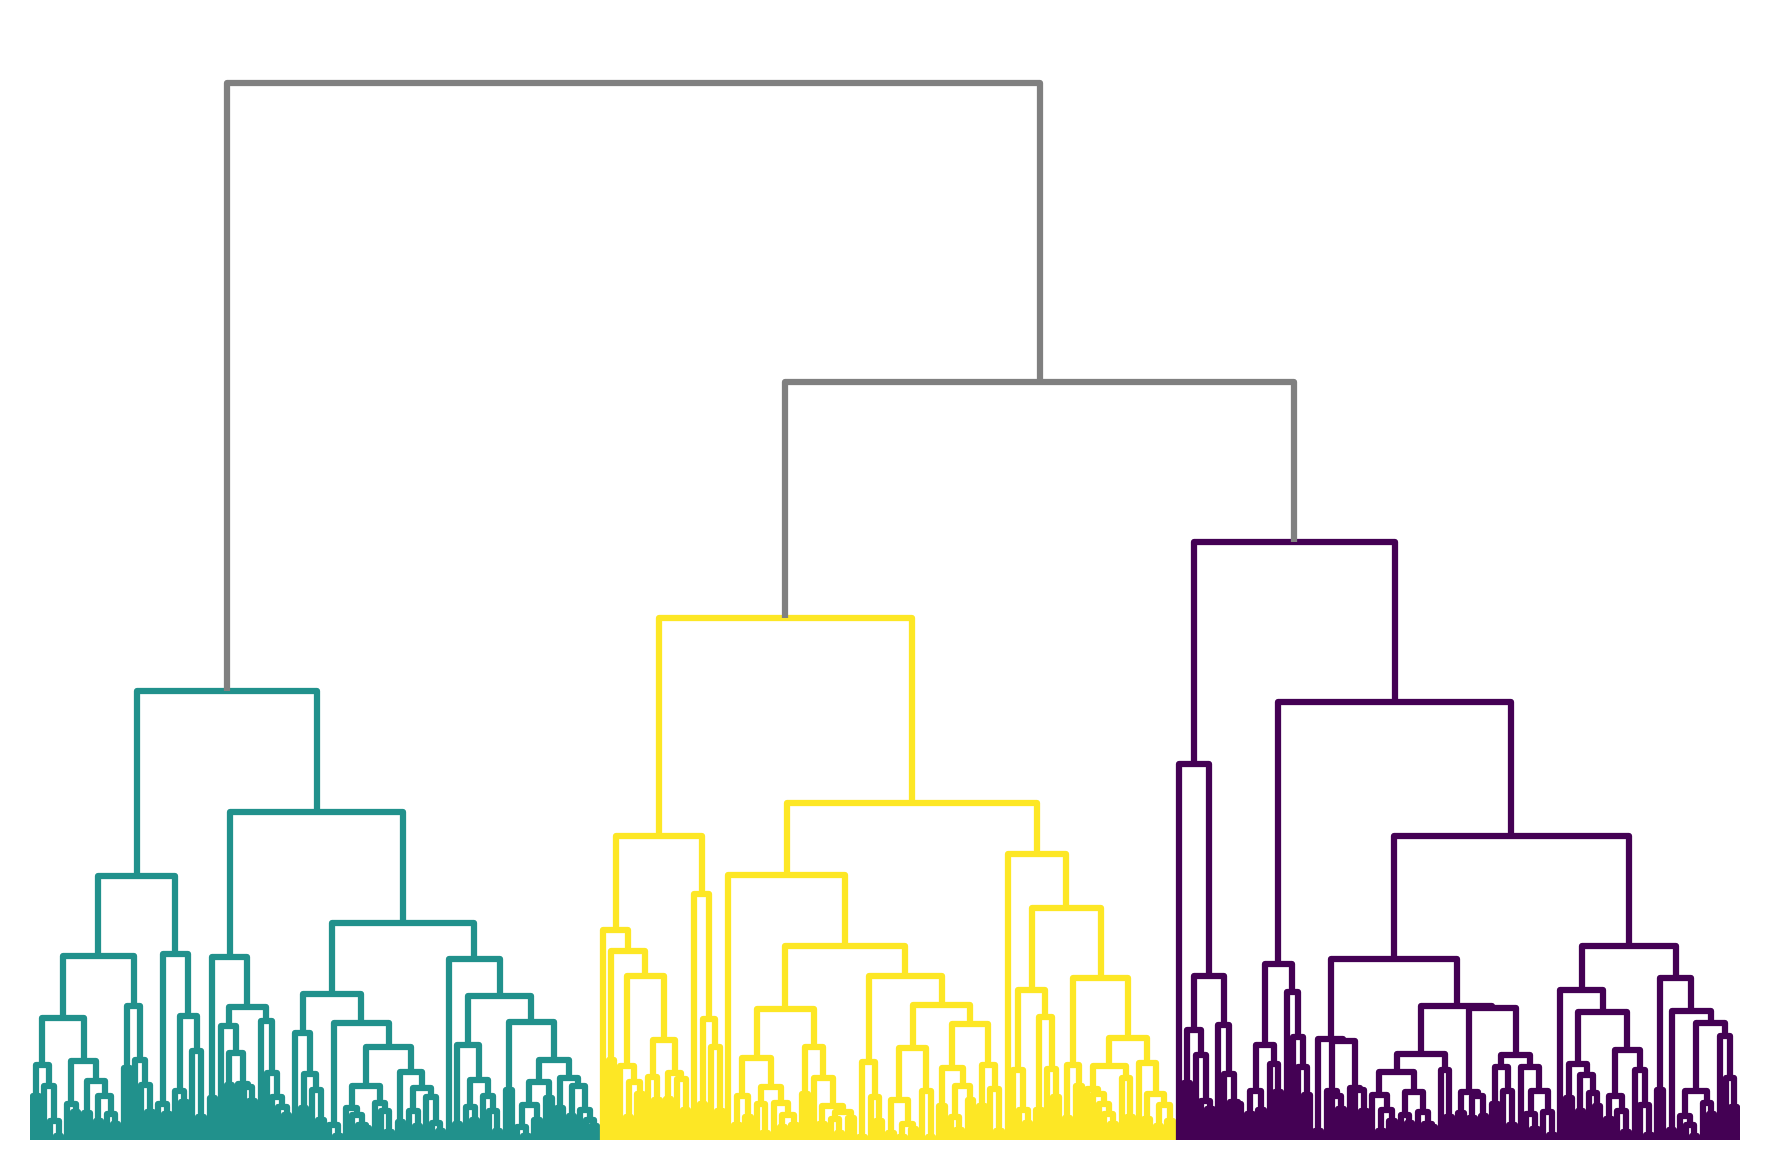

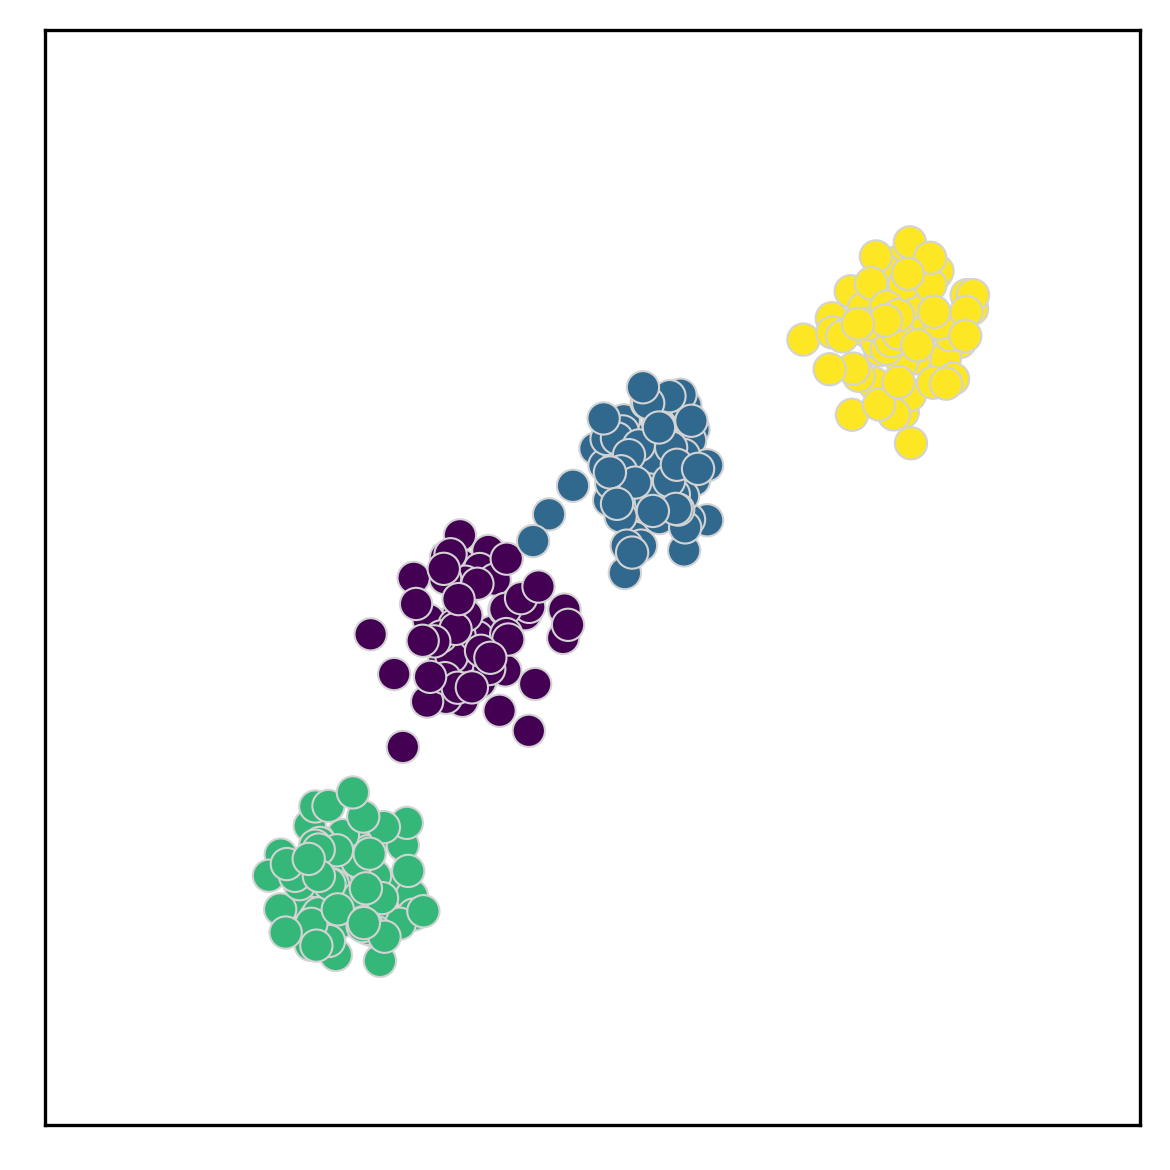

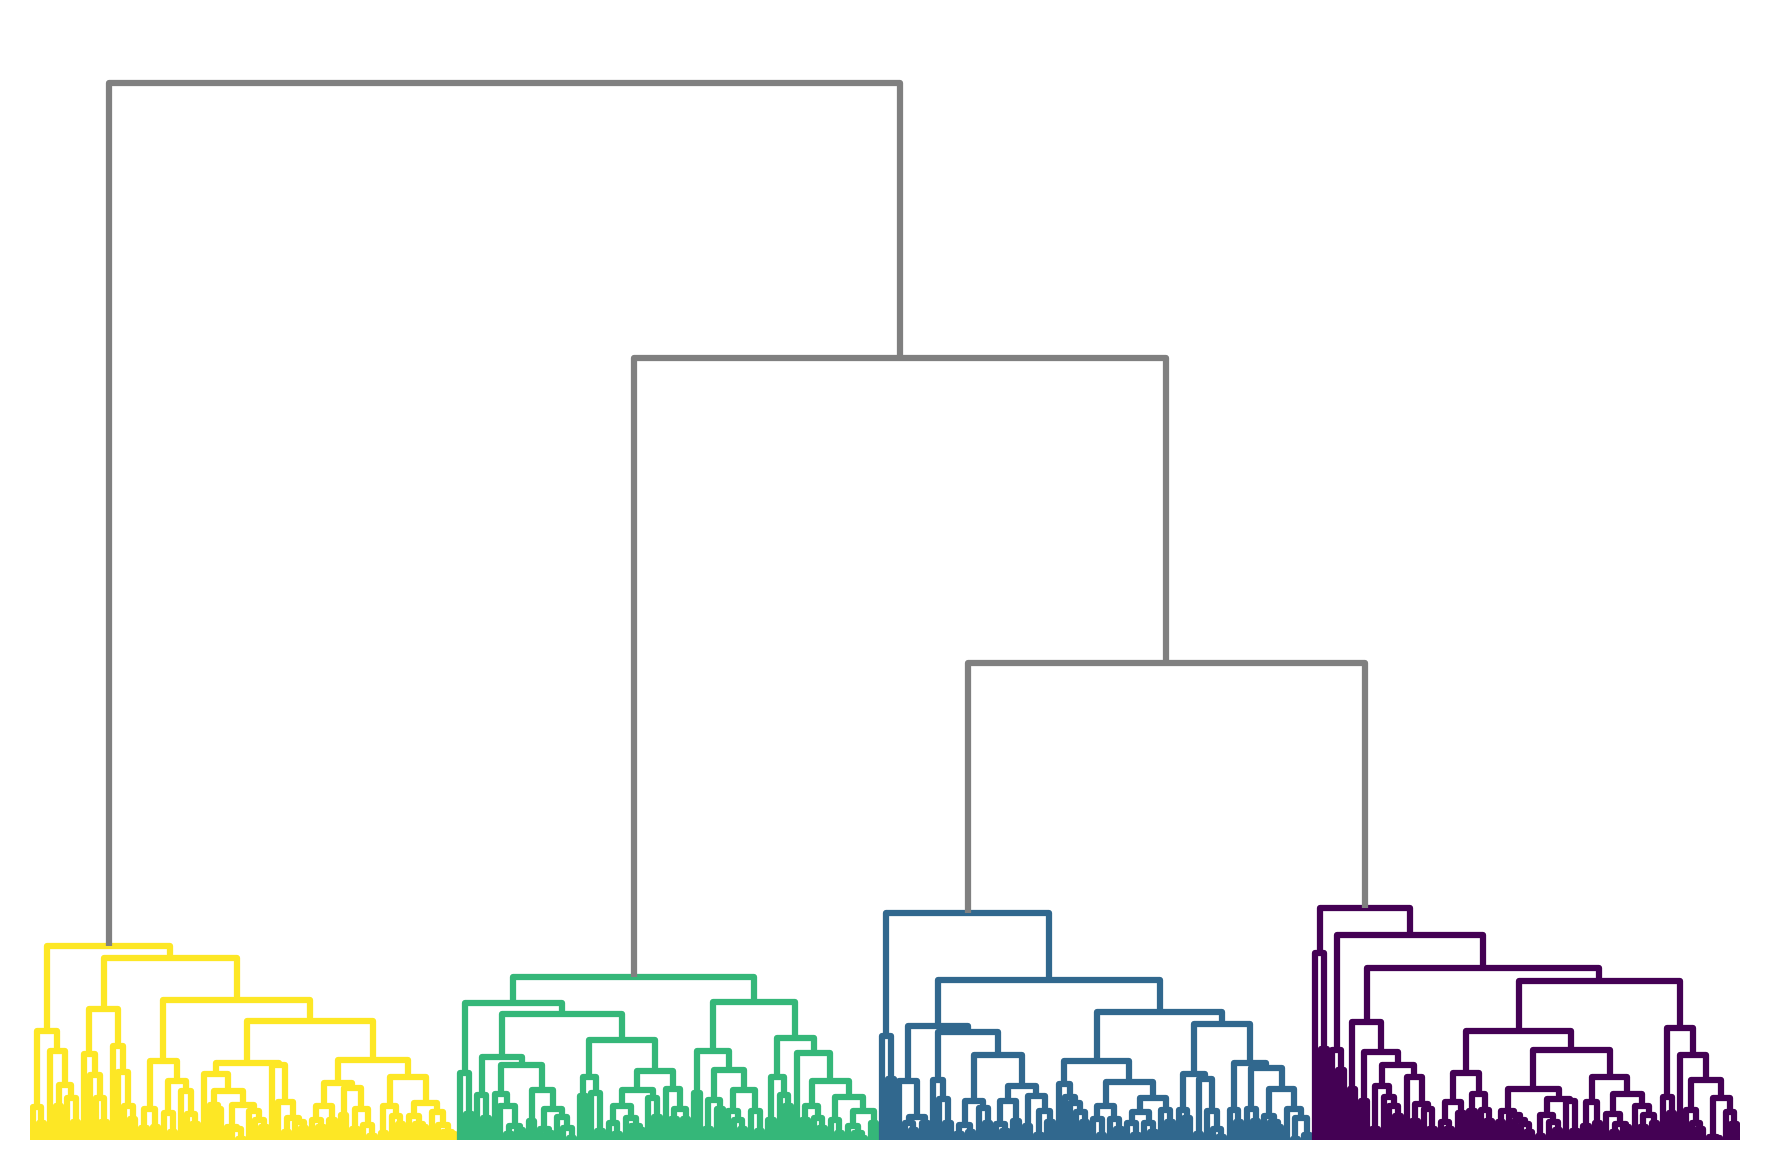

In [8]:
criterion = "average"
for n_clusters, data, name in zip(
    (2, 3, 4), (moons, ellipses, spheres), ("moons", "ellipses", "spheres")
):
    plot_scatter(
        data,
        cluster.AgglomerativeClustering,
        filename=img / f"hierarchical_{name}.pdf",
        linkage=criterion,
        n_clusters=n_clusters,
    )

    plot_dendogram(
        data,
        n_clusters,
        criterion=criterion,
        filename=img / f"dendogram_{name}.pdf",
        leaf_rotation=45,
    )

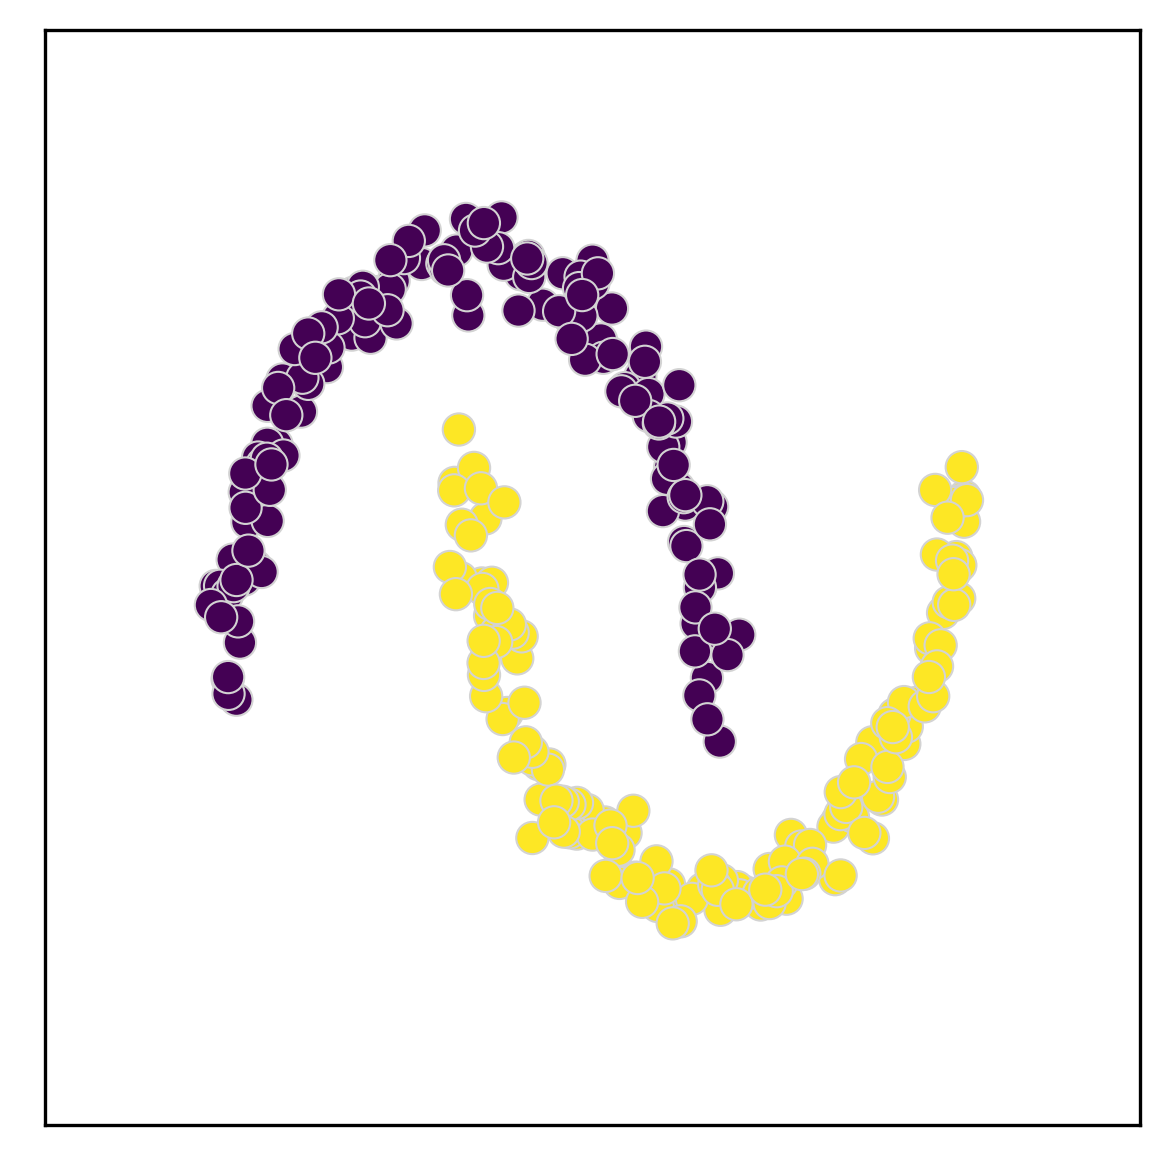

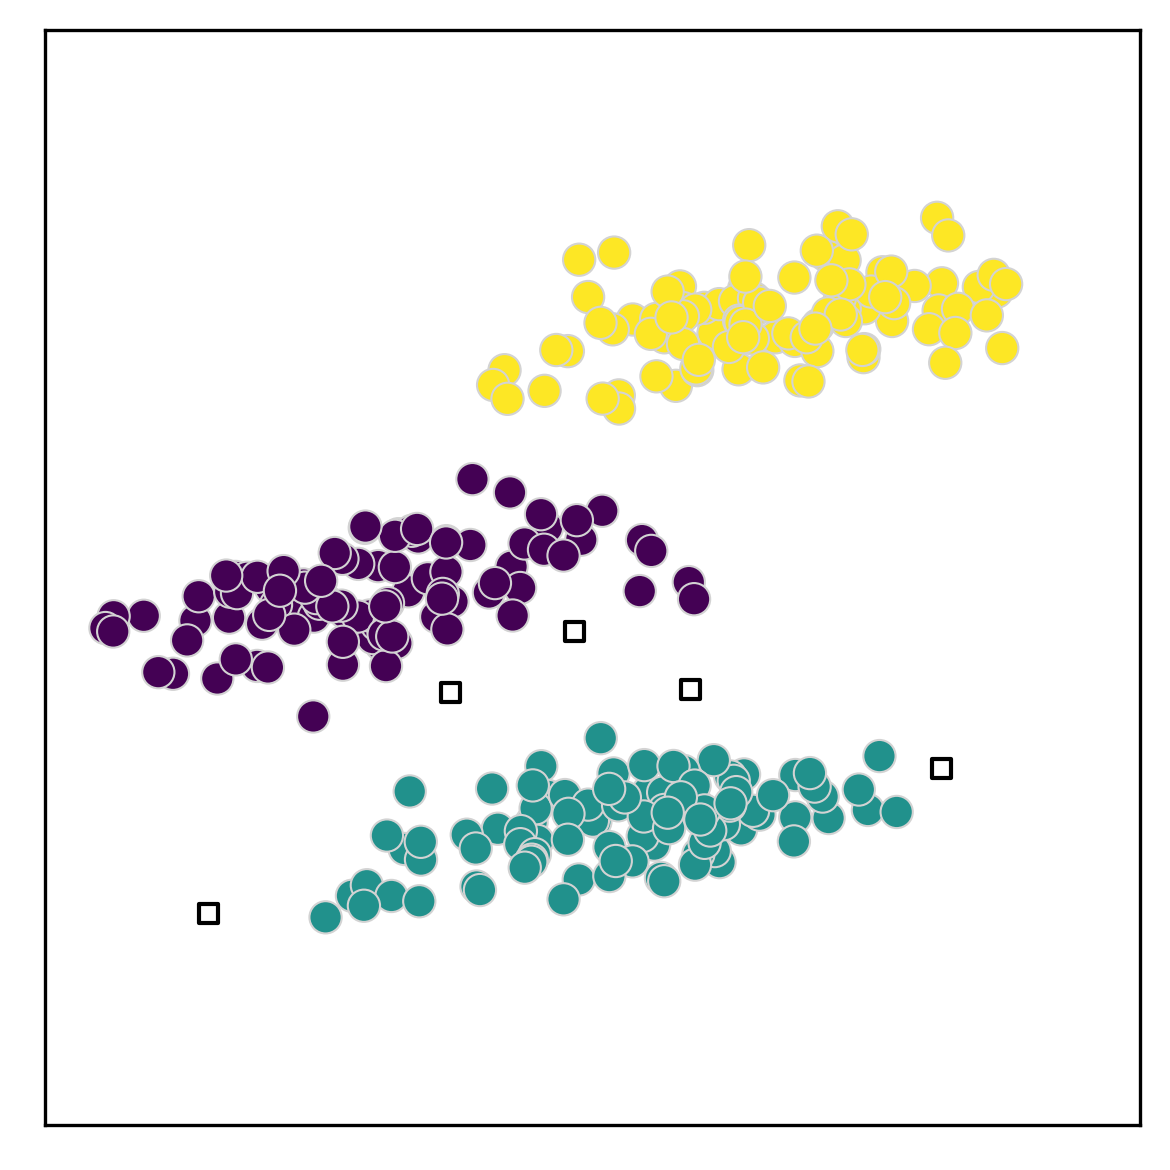

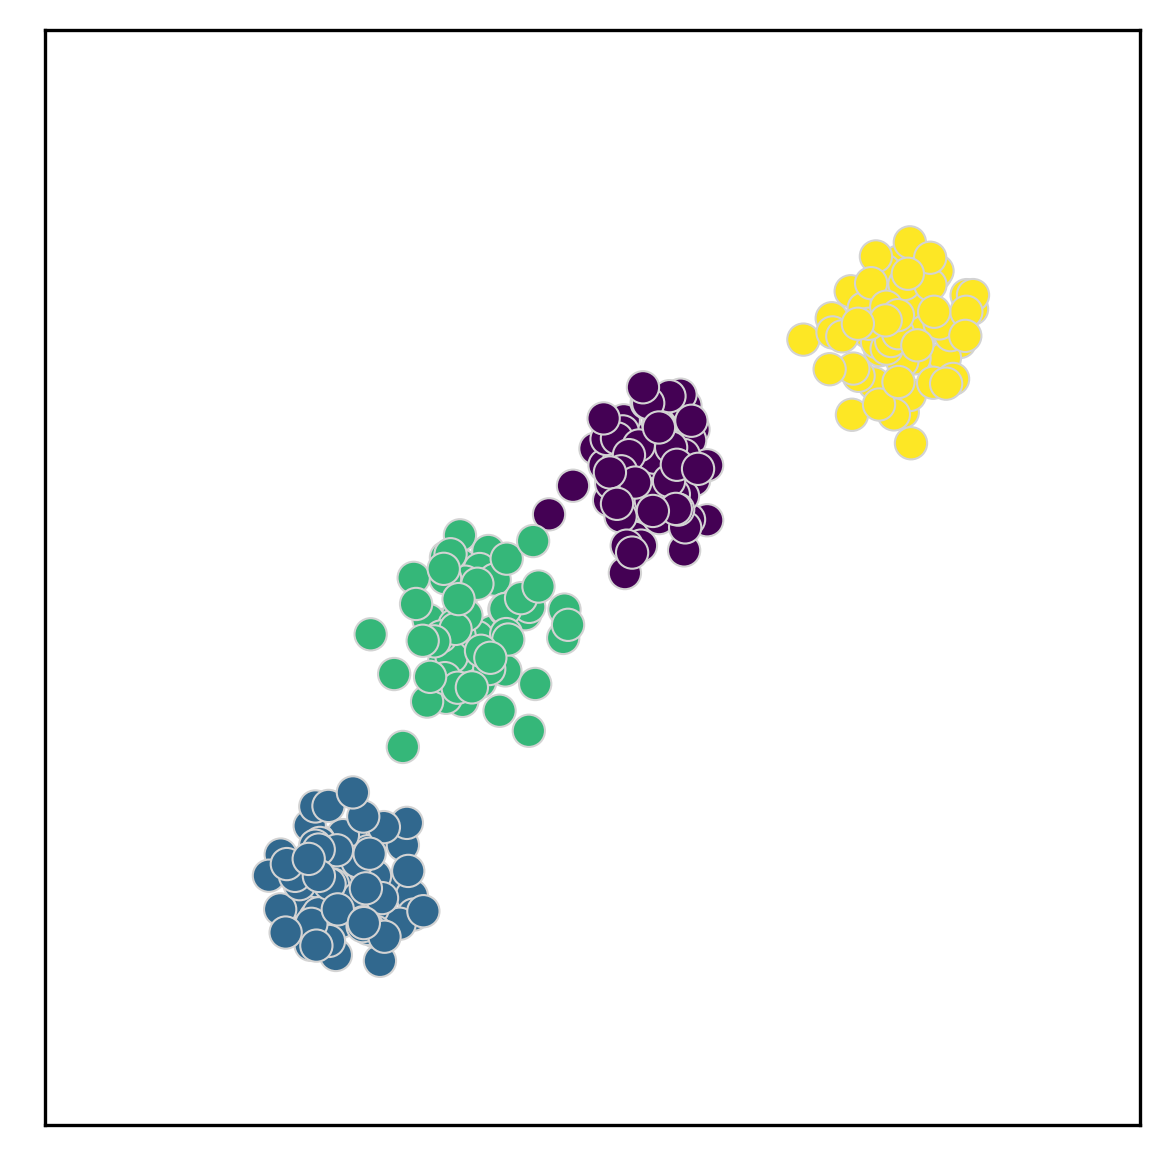

In [9]:
for data, name in zip(
    (moons, ellipses, spheres), ("moons", "ellipses", "spheres")
):
    plot_scatter(
        data,
        cluster.DBSCAN,
        filename=img / f"dbscan_{name}.pdf",
        eps=0.29,
    )